# Classifying images of everyday objects using a neural network

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
%matplotlib inline

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

In [3]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
dataset = CIFAR10(root='data/', train=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [6]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [7]:
test_ds = CIFAR10(root='data/', train=False, transform=transforms.ToTensor())

In [8]:
batch_size = 64

In [9]:
train_loader = DeviceDataLoader(DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True), device)
val_loader = DeviceDataLoader(DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True), device)
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True), device)

images.shape torch.Size([64, 3, 32, 32])


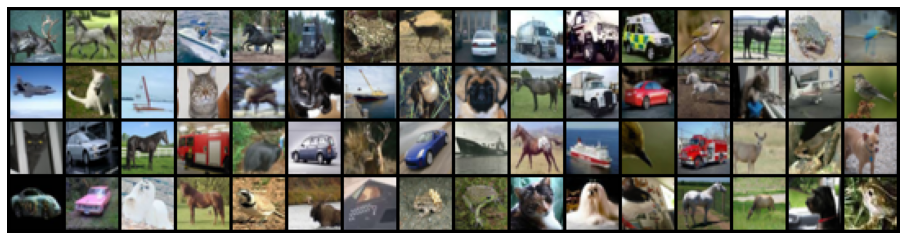

In [10]:
for images, _ in train_loader:
    print('images.shape', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).cpu().permute((1, 2, 0)))
    break

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # index
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
class ImageClassificationBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 10)        
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

In [13]:
model = to_device(ImageClassificationBase(), device)

In [14]:
training_losses, val_losses, val_acc = [], [], []
learning_rate = 0.003

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func):   
    for epoch in range(epochs): 
        running_loss = 0
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            running_loss += loss.item()  
        training_losses.append(running_loss / len(train_loader))
                    
        # Validation phase
        with torch.no_grad():
            model.eval()
            
            losses, accs = 0, 0
            for batch in val_loader:
                loss, acc = model.validation_step(batch)
                losses += loss.item()
                accs += acc.item()
            val_losses.append(losses / len(val_loader))
            val_acc.append(accs / len(val_loader))
            
        model.train()
        
        print("Epoch {}/{}".format(epoch+1, epochs),
             "Train_loss {:.4f}".format(training_losses[epoch]),
             "Val_loss {:.4f}".format(val_losses[epoch]),
             "Val_acc {:.4f}".format(val_acc[epoch]))

In [16]:
fit(20, learning_rate, model, train_loader, val_loader, optimizer)

Epoch 1/20 Train_loss 1.9183 Val_loss 1.7804 Val_acc 0.3481
Epoch 2/20 Train_loss 1.7326 Val_loss 1.7486 Val_acc 0.3732
Epoch 3/20 Train_loss 1.6633 Val_loss 1.7135 Val_acc 0.3981
Epoch 4/20 Train_loss 1.6164 Val_loss 1.6376 Val_acc 0.4193
Epoch 5/20 Train_loss 1.5902 Val_loss 1.6217 Val_acc 0.4096
Epoch 6/20 Train_loss 1.5613 Val_loss 1.6086 Val_acc 0.4262
Epoch 7/20 Train_loss 1.5406 Val_loss 1.5764 Val_acc 0.4331
Epoch 8/20 Train_loss 1.5260 Val_loss 1.6146 Val_acc 0.4278
Epoch 9/20 Train_loss 1.5124 Val_loss 1.5820 Val_acc 0.4306
Epoch 10/20 Train_loss 1.4927 Val_loss 1.5461 Val_acc 0.4430
Epoch 11/20 Train_loss 1.4793 Val_loss 1.5861 Val_acc 0.4324
Epoch 12/20 Train_loss 1.4719 Val_loss 1.5547 Val_acc 0.4434
Epoch 13/20 Train_loss 1.4541 Val_loss 1.6017 Val_acc 0.4377
Epoch 14/20 Train_loss 1.4474 Val_loss 1.5548 Val_acc 0.4411
Epoch 15/20 Train_loss 1.4305 Val_loss 1.5867 Val_acc 0.4345
Epoch 16/20 Train_loss 1.4304 Val_loss 1.5070 Val_acc 0.4624
Epoch 17/20 Train_loss 1.4185 Val

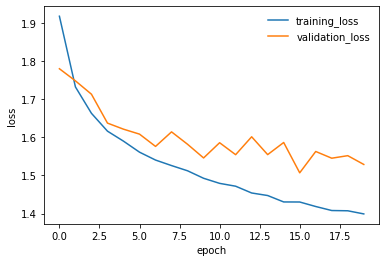

In [17]:
plt.plot(training_losses, label='training_loss')
plt.plot(val_losses, label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(frameon=False)

In [18]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 3 , Predicted: 3


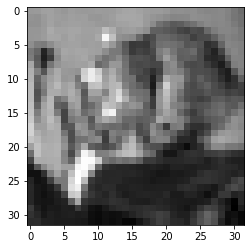

In [20]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))